# spotidata Interactive
Uses the spotidata command-line toolsuite to fetch songs from your saved music library, saved albums, and playlists, output/analyze/graph the data, and generate playlists from the source music with feature filters.

## Setup

In [1]:
import sys
sys.path.append('../')

import api.spotify as spotify
import api.utils as utils

from api.spotify import FeatureType, FeatureFilter

import clt.input_tools as clinput
import clt.spotidata as spotidata
import clt.visualizer as viz

First, we need to load the application data and username, and login.

In [2]:
username, scope = spotidata.boot('config.yml')
with spotify.login(username, scope) as sp_login:
    sp = sp_login

## Music Sources
Now, you'll need to choose where you want the source music to come from. You can either specify these using the picker below, which allows you choose individual playlists, indivudual albums (from the ones you've saved to your library), and whether or not to use all the songs you individually saved to your library.

In [3]:
# Music source picker
use_saved_tracks = clinput.input_boolean("Do you want me to analyze your saved songs?")
print()
print("Saved Albums:")
queried_albums = clinput.input_sublist("Which albums would you like to include in the analysis?", sp.get_saved_albums())
print()
print("Playlists:")
queried_playlists = clinput.input_sublist("Which playlists would you like to include in the analysis?", sp.get_playlists())

print("="*12)
print("including songs from:")
if use_saved_tracks:
    print("  - your Saved Music library")
if len(queried_albums) != 0:
    print("  - the following albums: {}".format(utils.get_english_list(queried_albums)))
if len(queried_playlists) != 0:
    print("  - the following playlists: {}".format(utils.get_english_list(queried_playlists)))

Do you want me to analyze your saved songs? (enter 'y' or 'n'): n

Saved Albums:
  [0] Origins (Deluxe) by Imagine Dragons
  [1] The Click by AJR
  [2] Neotheater by AJR
  [3] Social Cues by Cage The Elephant
  [4] Blurryface by Twenty One Pilots
  [5] Trench by Twenty One Pilots
Which albums would you like to include in the analysis? (enter a comma-separated list of numbers and ranges (ex: '1,3,5-10'), with valid indecies and range endpoint between 0 to 5, inclusive): 

Playlists:
  [0] vibe n' move
  [1] move
  [2] yerb
  [3] caffeine
  [4] chill
  [5] even chiller
  [6] what ronak listens to
  [7] bippity bops
  [8] chill bops
  [9] we boolin' n we boppin'
  [10] des rocs
  [11] cage the elephant
  [12] arrested youth
  [13] sam tinnesz
  [14] the score
  [15] grandson
  [16] foreign air
  [17] the neighbourhood
  [18] the unlikely candidates
  [19] twenty one pilots
  [20] the glitch mob
  [21] listen to these things
  [22] Your Top Songs 2019
  [23] Tastebreakers
  [24] Your Top S

Now, we can pull all tracks from those sources and get the features, courtesy of the Spotify API.

In [4]:
print("Fetching songs...")
tracks = sp.get_tracks(use_saved_tracks, [album.id for album in queried_albums], [playlist.id for playlist in queried_playlists])
print("   Done.")

print("Getting features...")
for track in tracks:
    track.load_features(sp)
print("   Done.")

Fetching songs...
   Done.
Getting features...
   Done.


If you'd like, you can print out all of the tracks, their artists, and their features in a delimeted spreadsheet format. Unfortunaely, because of all of the commas present in titles and artists, you might not be able to use a CSV-format, so specify the delimeter to your liking.

In [ ]:
delimiter = '---'
for line in spotidata.get_delimited_spreadsheet(tracks, delimiter):
    print(line)

## Feature Visualization
Because we have a lot of numbers, we can make fun histograms and pie charts and bar graphs for all of the music you selected.

The actual definition of each of the features can be found on [Spotify's API docs, linked here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/#audio-features-object).

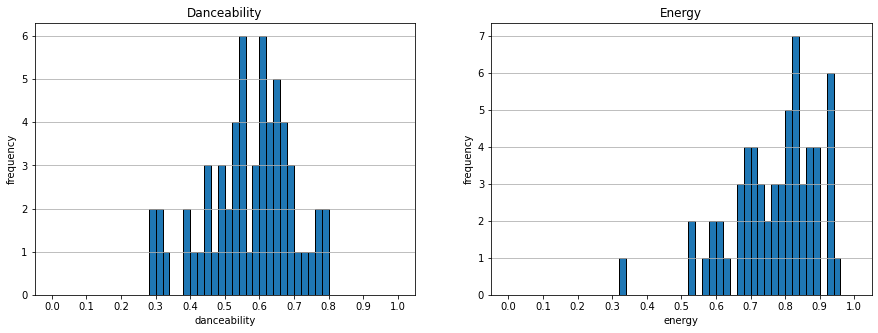

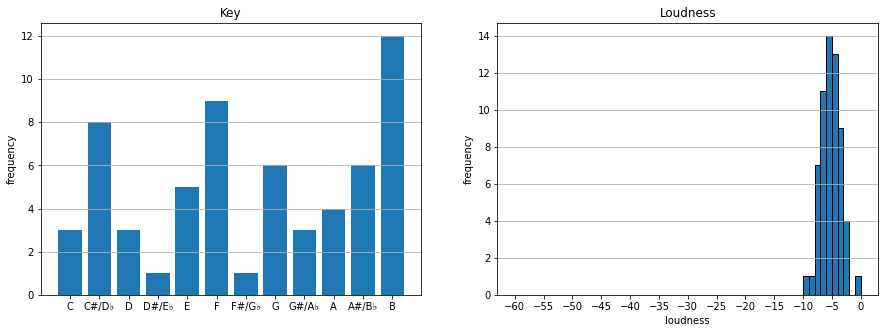

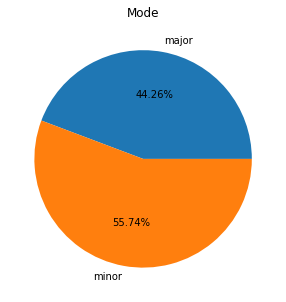

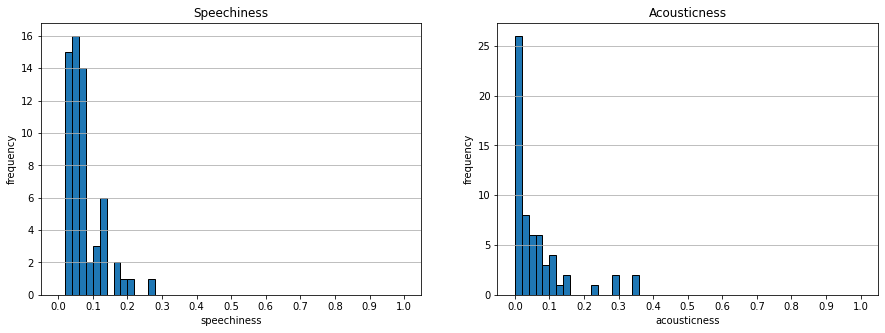

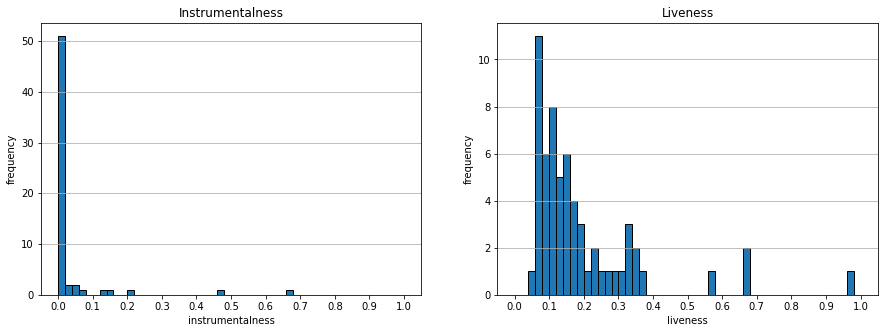

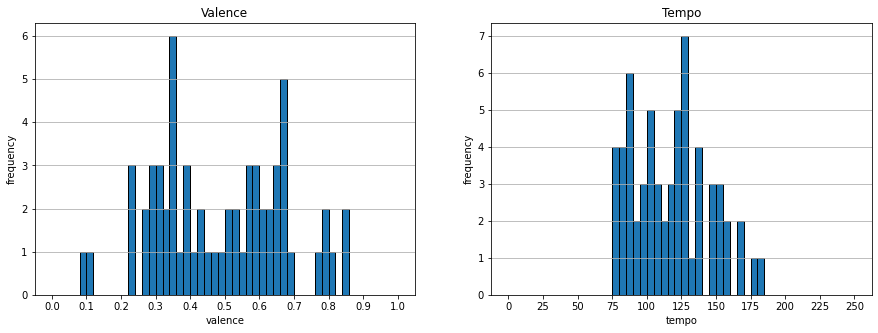

In [5]:
%matplotlib inline
viz.plot_all_features(tracks)

## Feature Filtering
In addition to just looking at the distribution of features for the songs, we can also get subsets of these songs based on `FeatureFilter`s, which are defined on ranges (for the numerical features) or lists of values (for the discrete-valued filters of key and mode).

In addition to the `Track.satisfies_all(filters)` and `Track.satsisfies_any(filters)`, you can also use `FeatureFilter.is_satisfied_by(track)` to make more complex filter predicates.

In [ ]:
# These filters attempt to make a lower-energy playlist.
filters = [
    FeatureFilter(FeatureType.ENERGY,       min_val=   0.0, max_val=   0.6),
    FeatureFilter(FeatureType.TEMPO,        min_val=   0.0, max_val= 130.0),
    FeatureFilter(FeatureType.LOUDNESS,     min_val= -60.0, max_val=  -7.0)
]

predicate = lambda track : track.satisfies_all(filters)

In [ ]:
# These filters attempt to make a dance-y playlist
filters = [
    FeatureFilter(FeatureType.ENERGY,         min_val=    0.6,  max_val=    1.0),
    FeatureFilter(FeatureType.DANCEABILITY,   min_val=    0.65, max_val=    1.0)
]

predicate = lambda track : track.satisfies_all(filters)

In [ ]:
# These filters attempt to make a very high energy playlist
filters = [
    FeatureFilter(FeatureType.ENERGY,         min_val=    0.85, max_val=    1.0)
]

predicate = lambda track : track.satisfies_all(filters)

Now, we can get the tracks that satisfy our predicate...

In [ ]:
filtered_tracks = spotify.get_tracks_that_satisfy_predicate(tracks, predicate)

visualize them with respect to our source songs...

In [ ]:
viz.plot_all_features(tracks, filtered_tracks)

and create a playlist with those songs.

In [ ]:
sp.create_playlist("vibes", filtered_tracks)